<a href="https://colab.research.google.com/github/ParthikB/Vohoo-Tensorflow/blob/master/flowers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import numpy as np
import os
import matplotlib.pyplot as plt
import glob, shutil

Using TensorFlow backend.


In [0]:
_URL = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

zip_file = tf.keras.utils.get_file(origin=_URL,
                                   fname="flower_photos.tgz",
                                   extract=True)

base_dir = os.path.join(os.path.dirname(zip_file), 'flower_photos')

In [0]:
classes = ['roses', 'daisy', 'dandelion', 'sunflowers', 'tulips']

In [17]:
for cl in classes:
  img_path = os.path.join(base_dir, cl)
  images = glob.glob(img_path + '/*.jpg')
  print("{}: {} Images".format(cl, len(images)))
  train, val = images[:round(len(images)*0.8)], images[round(len(images)*0.8):]

  for t in train:
    if not os.path.exists(os.path.join(base_dir, 'train', cl)):
      os.makedirs(os.path.join(base_dir, 'train', cl))
    shutil.move(t, os.path.join(base_dir, 'train', cl))

  for v in val:
    if not os.path.exists(os.path.join(base_dir, 'val', cl)):
      os.makedirs(os.path.join(base_dir, 'val', cl))
    shutil.move(v, os.path.join(base_dir, 'val', cl))

roses: 641 Images
daisy: 633 Images
dandelion: 898 Images
sunflowers: 699 Images
tulips: 799 Images


In [58]:
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

total_train = 0
total_val   = 0

for class_ in classes:
  total_train += len(os.listdir(os.path.join(train_dir, class_)))
  total_val   += len(os.listdir(os.path.join(val_dir, class_)))
  
print("Total Training samples   :", total_train)
print("Total Validation samples :", total_val)

Total Training samples   : 2935
Total Validation samples : 735


## Data Augmentation

In [0]:
BATCH_SIZE = 100
IMG_SHAPE  = 150

In [23]:
image_gen = ImageDataGenerator(rescale=1./255,
                               horizontal_flip=True,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               zoom_range=0.2,
                               shear_range=0.2,
                               rotation_range=40,
                               fill_mode='nearest')

train_data = image_gen.flow_from_directory(directory=train_dir,
                                           shuffle=True,
                                           batch_size=BATCH_SIZE,
                                           target_size=(IMG_SHAPE, IMG_SHAPE),
                                           class_mode='binary')

Found 2935 images belonging to 5 classes.


In [25]:
image_gen = ImageDataGenerator(rescale=1./255)

val_data = image_gen.flow_from_directory(directory=val_dir,
                                         batch_size=BATCH_SIZE,
                                         target_size=(IMG_SHAPE, IMG_SHAPE),
                                         class_mode='binary')

Found 735 images belonging to 5 classes.


In [0]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

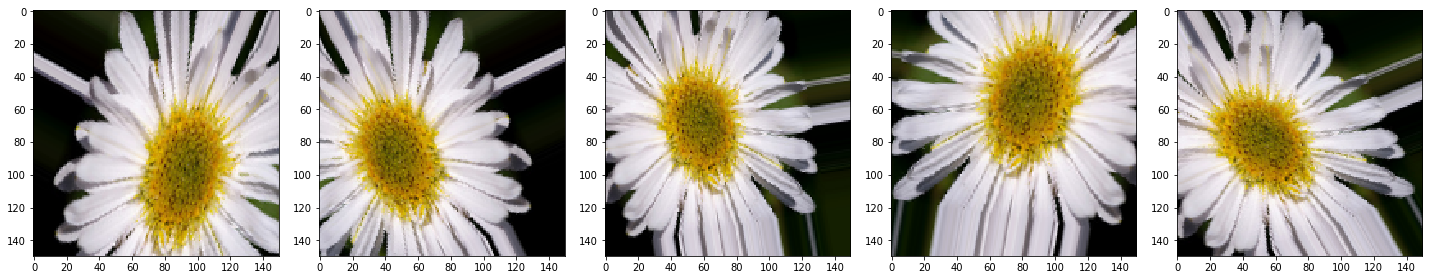

In [33]:
plotImages([train_data[0][0][1] for i in range(5)])

## DNN (structure)

In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SHAPE, IMG_SHAPE, 3)),
    tf.keras.layers.MaxPool2D(2, 2),
    
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(2, 2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(2, 2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(2, 2),
    
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])



In [0]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])

## DNN (training)

In [74]:
EPOCHS = 100

history = model.fit_generator(train_data, 
                    steps_per_epoch=int(np.ceil(total_train/BATCH_SIZE)),
                    validation_data=val_data,
                    validation_steps=int(np.ceil(total_val/BATCH_SIZE)),
                    epochs=EPOCHS)

Epoch 1/100
30/30 [==============================] - 24s 786ms/step - loss: 1.5325 - acc: 0.2964 - val_loss: 1.3069 - val_acc: 0.4395
Epoch 2/100
30/30 [==============================] - 21s 704ms/step - loss: 1.2839 - acc: 0.4129 - val_loss: 1.2367 - val_acc: 0.4435
Epoch 3/100
30/30 [==============================] - 21s 696ms/step - loss: 1.2166 - acc: 0.4610 - val_loss: 1.1229 - val_acc: 0.5102
Epoch 4/100
30/30 [==============================] - 21s 700ms/step - loss: 1.2144 - acc: 0.4801 - val_loss: 1.1223 - val_acc: 0.4966
Epoch 5/100
30/30 [==============================] - 21s 694ms/step - loss: 1.1426 - acc: 0.5182 - val_loss: 1.0181 - val_acc: 0.5660
Epoch 6/100
30/30 [==============================] - 21s 691ms/step - loss: 1.1077 - acc: 0.5336 - val_loss: 0.9840 - val_acc: 0.5973
Epoch 7/100
30/30 [==============================] - 21s 692ms/step - loss: 1.0489 - acc: 0.5673 - val_loss: 0.9016 - val_acc: 0.6231
Epoch 8/100
30/30 [==============================] - 21s 685ms

In [0]:
train_loss = history.history['loss']
train_acc  = history.history['acc']

val_loss   = history.history['val_loss']
val_acc    = history.history['val_acc']

epochs = range(100)

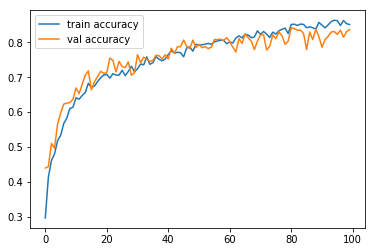

In [84]:


plt.plot(epochs, train_acc, label='train accuracy')
plt.plot(epochs, val_acc, label='val accuracy')
plt.legend()